# 뉴스 카테고리 다중분류 프로젝트 (Vocab = 5000)
#### 주제
- Vocabulary Size 변경해서 시도해보기
    1. 모든 단어 사용
    2. 빈도수 상위 5000개의 단어만 사용
    3. 직접 단어 개수 설정해서 사용 
- 모델 3가지 이상 사용: SVC, LinearRegression, RandomForest, Voting
    - RNN, 1-D CNN 등 딥러닝 모델 중 하나 선택해서 머신러닝과 결과 비교하기

In [1]:
from tensorflow.keras.datasets import reuters

In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 1.모든 단어 사용하기

## 1-1. 데이터 로드 및 벡터화

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [5]:
def check_data(x_train, y_train, x_test, y_test):
    # 훈련 및 테스트 샘플 수 확인
    print('훈련 샘플의 수: {}'.format(len(x_train)))
    print('테스트 샘플의 수: {}'.format(len(x_test)))
    
    # 클래스 수 확인
    num_classes = max(y_train) + 1
    print('클래스의 수 : {}'.format(num_classes))
    
    # 훈련 데이터 최대 길이 및 평균 길이 확인
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))
    
    plt.subplot(211)
    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.title("Length Distribution")
    
    # 각 클래스 빈도수 확인
    plt.subplot(212)
    sns.countplot(x=y_train)
    plt.title("Frequency of classes")
    plt.show()

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


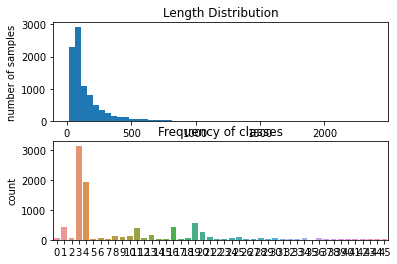

In [6]:
check_data(x_train, y_train, x_test, y_test)

In [7]:
def vectorize(x_train, x_test):
    # vocab 만들기
    word_index = reuters.get_word_index(path = "reuters_word_index.json")
    index_to_word = {index + 3 : word for word, index in word_index.items()}
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index] = token
    
    # index -> 원문 text 복원하기
    x_train_decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        x_train_decoded.append(t)
    
    x_test_decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        x_test_decoded.append(t)
    
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train_decoded)
    x_test_dtm = dtmvector.transform(x_test_decoded)
    
    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
    
    return x_train_tfidf, x_test_tfidf, x_train_decoded, x_test_decoded, word_index, index_to_word

In [8]:
x_train_tfidf, x_test_tfidf, x_train_decoded, x_test_decoded, word_index, index_to_word = vectorize(x_train, x_test)

In [9]:
x_train_tfidf.shape

(8982, 4867)

In [10]:
x_test_tfidf.shape

(2246, 4867)

## 1-2. 머신러닝 모델 학습하기

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### LogisticRegression

In [13]:
start_time = time.time()
lr = LogisticRegression(C=10000, penalty = "l2", max_iter = 3000)
lr.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_lr = end_time - start_time 

print(f"training time for logistic regression:{learning_time_lr: .2f} 초")

training time for logistic regression: 536.41 초


In [40]:
predicted = lr.predict(x_test_tfidf)
acc_lr = accuracy_score(y_test, predicted)
f1_lr = f1_score(y_test, predicted, average = 'weighted')
print("정확도: ", acc_lr)
print("f1-score:", f1_lr)
print(classification_report(y_test, predicted, zero_division = 0))

정확도:  0.8036509349955476
f1-score: 0.7985602317931111
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.77      0.75       105
           2       0.76      0.80      0.78        20
           3       0.90      0.93      0.91       813
           4       0.80      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.66      0.71      0.68        38
           9       0.81      0.88      0.85        25
          10       0.89      0.83      0.86        30
          11       0.64      0.73      0.69        83
          12       0.57      0.31      0.40        13
          13       0.63      0.65      0.64        37
          14       0.50      0.50      0.50         2
          15       0.75      0.33      0.46         9
          16       0.70    

### RandomForest

In [15]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators = 5, random_state = 0)
rf.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_rf = end_time - start_time 

print(f"training time for RandomForest:{learning_time_rf: .2f} 초")

training time for RandomForest: 1.29 초


In [41]:
predicted = rf.predict(x_test_tfidf)
acc_rf = accuracy_score(y_test, predicted)
f1_rf = f1_score(y_test, predicted, average = 'weighted')
print("정확도:", acc_rf) 
print("f1-score:", f1_rf)
print(classification_report(y_test, predicted, zero_division = 0))

정확도: 0.701246660730187
f1-score: 0.6770217603524399
              precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.42      0.78      0.55       105
           2       0.44      0.35      0.39        20
           3       0.84      0.90      0.87       813
           4       0.68      0.84      0.75       474
           5       0.00      0.00      0.00         5
           6       0.86      0.43      0.57        14
           7       1.00      0.33      0.50         3
           8       0.59      0.53      0.56        38
           9       0.71      0.40      0.51        25
          10       0.89      0.53      0.67        30
          11       0.57      0.69      0.62        83
          12       0.33      0.15      0.21        13
          13       0.46      0.32      0.38        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16       0.70      

### CalibratedClassifierCV + linearSVC

In [17]:
from sklearn.calibration import CalibratedClassifierCV

start_time = time.time()
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
calibrated_model = CalibratedClassifierCV(lsvc, cv = 5)
calibrated_model.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_ccsvc = end_time - start_time

print(f"training time for CalibratedSVC:{learning_time_ccsvc: .2f} 초")

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


training time for CalibratedSVC: 462.52 초


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [42]:
predicted = calibrated_model.predict(x_test_tfidf)
acc_ccsvc = accuracy_score(y_test, predicted)
f1_ccsv = f1_score(y_test, predicted, average = 'weighted')
print("정확도: ", acc_ccsvc)
print("f1-score: ", f1_ccsv)
print(classification_report(y_test, predicted, zero_division = 0))

정확도:  0.794746215494212
f1-score:  0.7840837414249962
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.76      0.78      0.77       105
           2       0.79      0.75      0.77        20
           3       0.88      0.94      0.91       813
           4       0.78      0.87      0.82       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.69      0.66      0.68        38
           9       0.84      0.84      0.84        25
          10       0.92      0.80      0.86        30
          11       0.66      0.73      0.69        83
          12       0.50      0.31      0.38        13
          13       0.62      0.57      0.59        37
          14       1.00      0.50      0.67         2
          15       0.67      0.22      0.33         9
          16       0.70    

### Voting

In [19]:
start_time = time.time()
voting_classifier = VotingClassifier(
    estimators = [
    ('lr', lr), ('rf', rf), ('ccsvc', calibrated_model)],
    voting = 'soft'
)
voting_classifier.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_voting = end_time - start_time

print(f"training time for SVC:{learning_time_voting: .2f} 초")

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


training time for SVC: 1546.97 초


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [43]:
predicted = voting_classifier.predict(x_test_tfidf)
acc_voting = accuracy_score(y_test, predicted)
f1_voting = f1_score(y_test, predicted, average = 'weighted')
print("정확도: ", acc_voting)
print("f1-score: ", f1_voting)
print(classification_report(y_test, predicted, zero_division = 0))

정확도:  0.8076580587711487
f1-score:  0.7997169279799828
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.70      0.77      0.74       105
           2       0.71      0.75      0.73        20
           3       0.90      0.93      0.92       813
           4       0.79      0.88      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.70      0.74      0.72        38
           9       0.81      0.84      0.82        25
          10       0.92      0.80      0.86        30
          11       0.66      0.73      0.69        83
          12       0.57      0.31      0.40        13
          13       0.65      0.65      0.65        37
          14       0.50      0.50      0.50         2
          15       0.67      0.22      0.33         9
          16       0.71   

### DeepLearning - LSTM

In [27]:
# 패딩 추가
maxlen = 440

word_to_index = {word:index for index, word in index_to_word.items()}
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, value = word_to_index["<pad>"], padding = 'pre', maxlen = maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, value = word_to_index["<pad>"], padding = 'pre', maxlen = maxlen)

In [28]:
# test, val 나누기 
from sklearn.model_selection import train_test_split

x_train_partial, x_val, y_train_partial, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2024)
x_train_partial.shape, y_train_partial.shape, x_val.shape, y_val.shape

((7185, 440), (7185,), (1797, 440), (1797,))

In [29]:
num_classes = np.max(y_train) + 1
num_classes

46

In [33]:
# 모델 정의
vocab_size = 5000
word_vector_dim = 128

model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(46, activation = "softmax")
])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                2990      
Total params: 782,830
Trainable params: 782,830
Non-trainable params: 0
_________________________________________________________________


In [34]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model_rnn.keras", monitor = "val_accuracy", verbose = 1, save_best_only = True)

In [36]:
start_time = time.time()
model_rnn.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history_rnn = model_rnn.fit(x_train_partial, 
                            y_train_partial, 
                            epochs = 100, 
                            batch_size = 512,
                            validation_data = (x_val, y_val),
                            callbacks = [checkpoint])
end_time = time.time()
learning_time_rnn = end_time - start_time
print(f"training time for rnn:{learning_time_rnn: .2f} 초")

Epoch 1/100
15/15 [==============================] - 7s 207ms/step - loss: 3.2994 - accuracy: 0.3499 - val_loss: 2.6098 - val_accuracy: 0.3589

Epoch 00001: val_accuracy improved from -inf to 0.35893, saving model to best_model_rnn.keras
Epoch 2/100
15/15 [==============================] - 2s 106ms/step - loss: 2.5199 - accuracy: 0.3324 - val_loss: 2.4518 - val_accuracy: 0.3589

Epoch 00002: val_accuracy did not improve from 0.35893
Epoch 3/100
15/15 [==============================] - 2s 112ms/step - loss: 2.4319 - accuracy: 0.3499 - val_loss: 2.4196 - val_accuracy: 0.3589

Epoch 00003: val_accuracy did not improve from 0.35893
Epoch 4/100
15/15 [==============================] - 2s 113ms/step - loss: 2.4048 - accuracy: 0.3499 - val_loss: 2.3882 - val_accuracy: 0.3589

Epoch 00004: val_accuracy did not improve from 0.35893
Epoch 5/100
15/15 [==============================] - 2s 112ms/step - loss: 2.3618 - accuracy: 0.3499 - val_loss: 2.2409 - val_accuracy: 0.3589

Epoch 00005: val_accu

In [37]:
from tensorflow.keras.models import load_model

model_rnn = load_model("best_model_rnn.keras")
results_rnn = model_rnn.evaluate(x_test, y_test, verbose = 2)

71/71 - 2s - loss: 2.7957 - accuracy: 0.6380


In [38]:
predicted = model_rnn.predict(x_test)
predicted_classes = np.argmax(predicted, axis = 1)
print(classification_report(y_test, predicted_classes, zero_division = 0))

              precision    recall  f1-score   support

           0       0.31      0.42      0.36        12
           1       0.46      0.48      0.47       105
           2       0.26      0.45      0.33        20
           3       0.87      0.91      0.89       813
           4       0.78      0.79      0.78       474
           5       0.00      0.00      0.00         5
           6       0.62      0.36      0.45        14
           7       0.25      0.33      0.29         3
           8       0.44      0.29      0.35        38
           9       0.35      0.24      0.29        25
          10       0.35      0.23      0.28        30
          11       0.37      0.36      0.36        83
          12       0.33      0.23      0.27        13
          13       0.22      0.22      0.22        37
          14       0.20      0.50      0.29         2
          15       0.10      0.11      0.11         9
          16       0.35      0.56      0.43        99
          17       0.08    